In [67]:
import re
import numpy as np
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium

In [68]:
#read in data
beer_sales = pd.read_csv('./data/Beer_Permit_Locations.csv')

In [69]:
beer_sales['Mapped Location'].head(1)

0    5405 Harding PIKE\nNashville, TN 37205\n(36.09...
Name: Mapped Location, dtype: object

In [70]:
# running ReGex for cleaning Lat, Long
lat_lng_pattern = re.compile(r'\((.*),\s*(.*)\)', flags=re.MULTILINE)

def extract_lat_lng(address):
    try:
        lat_lng_match = lat_lng_pattern.search(address)
        lat = float(lat_lng_match.group(1))
        lng = float(lat_lng_match.group(2))
        return (lat, lng)
    except:
        return (np.NaN, np.NaN)  #it's important that our list be exactly as long as our df
    
lat_lngs = [extract_lat_lng(location) for location in beer_sales.loc[:, 'Mapped Location']]
beer_sales['lat'] = [lat for lat, lng in lat_lngs]
beer_sales['lng'] = [lng for lat, lng in lat_lngs]

In [71]:
beer_sales.head(2)

,Permit Number,Status,Permit Type,Permit SubType,Permit Sub Type Description,Date Entered,Date Issued,Parcel,Business Name,Business Owner,Address,City,State,Zip,Council District,Census Tract,Mapped Location,lat,lng
0,94-16001,ISSUED,BBPERMIT,ONSALES,BB - On Site Sales,08/18/1993,02/01/1994,13001010000,Sportsman's Grille,"Sportsman's Grille, Inc.",5405 Harding PIKE,Nashville,TN,37205.0,34.0,37018500.0,"5405 Harding PIKE\nNashville, TN 37205\n(36.09...",36.099462,-86.871678
1,15-17285,ISSUED,BBPERMIT,OFFSALES,BB - Off Site Sales,09/03/2015,09/25/2015,10504021900,GC Mart,Bander Inc,10 Fairfield AVE,Nashville,TN,37210.0,19.0,37014800.0,"10 Fairfield AVE\nNashville, TN 37210\n(36.147...",36.147658,-86.757759


In [72]:
beer_sales.columns

Index(['Permit Number', 'Status', 'Permit Type', 'Permit SubType',
       'Permit Sub Type Description', 'Date Entered', 'Date Issued', 'Parcel',
       'Business Name', 'Business Owner', 'Address', 'City', 'State', 'Zip',
       'Council District', 'Census Tract', 'Mapped Location', 'lat', 'lng'],
      dtype='object')

In [73]:
cop_calls = pd.read_csv('./data/Metro_Nashville_Davidson_County_Calls_For_Police_Service__2018_.csv')
cop_calls.head(2)

,Event Number,Call Received,Complaint Number,Shift,Tencode,Tencode Description,Tencode Suffix,Tencode Suffix Description,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Sector,Zone,Reporting Area (RPA),Latitude,Longitude,Mapped Location
0,PD201800000002,01/01/2018 12:00:00 AM,20180000002,C,96,Business Check,NaN,NaN,12,LOCATION/BUILDING SECURE,0.0,3RD AV N & JEFFERSON ST,7F62,C,13,4311.0,36.175,-86.785,"(36.175, -86.785)"
1,PD201800000003,01/01/2018 12:00:00 AM,20180000003,C,96,Business Check,NaN,NaN,12,LOCATION/BUILDING SECURE,2300.0,8TH AV S,821C,MT,23,6929.0,36.127,-86.778,"(36.127, -86.778)"


In [74]:
cop_calls.columns

Index(['Event Number', 'Call Received', 'Complaint Number', 'Shift', 'Tencode',
       'Tencode Description', 'Tencode Suffix', 'Tencode Suffix Description',
       'Disposition Code', 'Disposition Description', 'Block', 'Street Name',
       'Unit Dispatched', 'Sector', 'Zone', 'Reporting Area (RPA)', 'Latitude',
       'Longitude', 'Mapped Location'],
      dtype='object')

In [75]:
cop_calls.shape

(673549, 19)

In [76]:
#read in neighborhood geometry
neighborhoods = gpd.read_file('./data/Neighborhood Association Boundaries (GIS).geojson')
neighborhoods.head(1)

,name,geometry
0,Historic Buena Vista,(POLYGON ((-86.79511056795417 36.1757596496334...


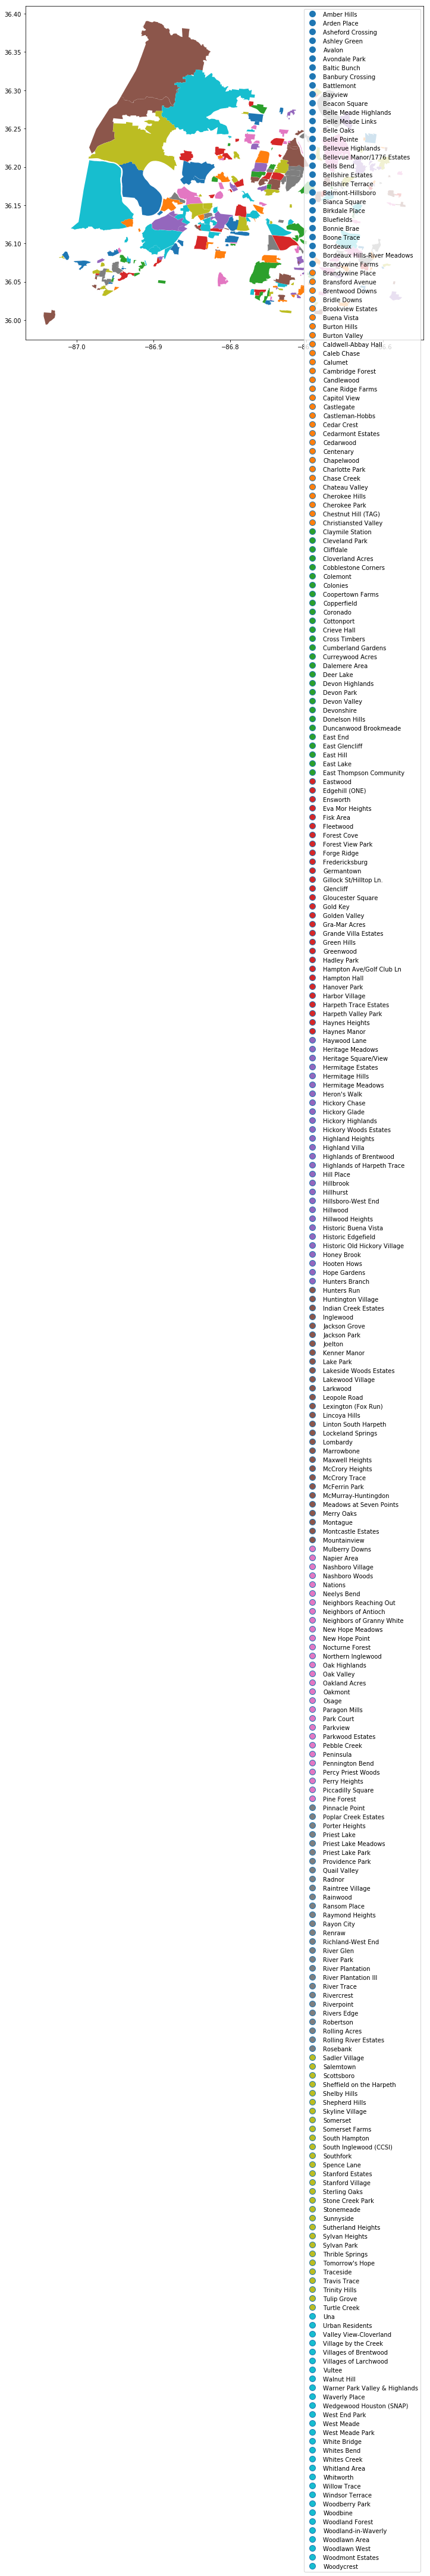

In [77]:
#geopandas handles legend styling if you pass a dict of keywords
leg_kwds = {'title': 'Neighborhoods', 'loc': 'upper left', 'bbox_to_anchor': (1, 1.03), 'ncol': 6}
neighborhoods.plot(column = 'name', figsize=(12, 12), legend = True)
plt.show()


In [78]:
#Create geometry field and convert beer_sales to GeoDataFrame
beer_sales['geometry'] = beer_sales.apply(lambda x: Point((float(x.lng), float(x.lat))), axis=1)
beer_map = gpd.GeoDataFrame(beer_sales, crs = neighborhoods.crs, geometry = beer_sales['geometry'])

In [79]:
neighborhood_beer = gpd.sjoin(neighborhoods, beer_map, op = 'contains')

C:\Users\josh\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2831: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [80]:
neighborhood_beer.head(1)

,name,geometry,index_right,Permit Number,Status,Permit Type,Permit SubType,Permit Sub Type Description,Date Entered,Date Issued,...,Business Owner,Address,City,State,Zip,Council District,Census Tract,Mapped Location,lat,lng
0,Historic Buena Vista,(POLYGON ((-86.79511056795417 36.1757596496334...,1302,09-16526,ISSUED,BBPERMIT,OFFSALES,BB - Off Site Sales,07/29/2009,08/27/2009,...,Kroger Limited Partnership,800 Monroe ST,Nashville,TN,37211.0,19.0,37019400.0,"800 Monroe ST\nNashville, TN 37211\n(36.174887...",36.174887,-86.794004


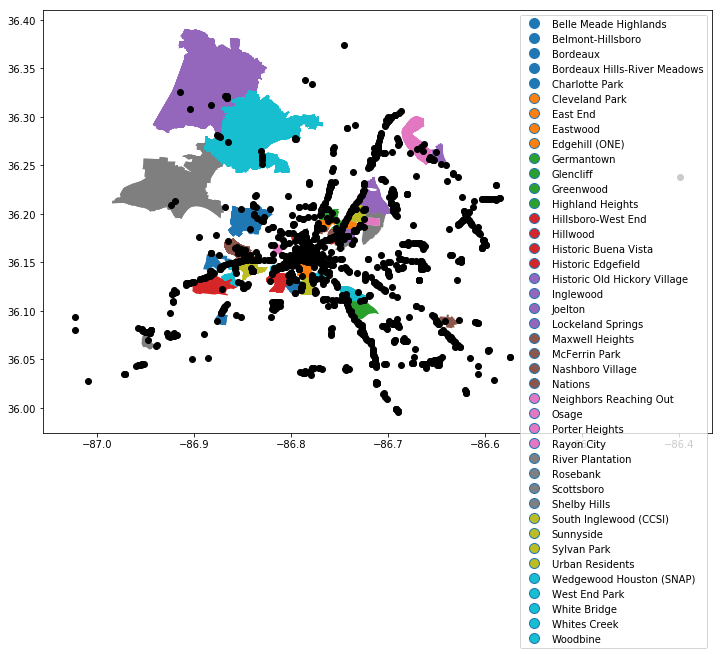

In [81]:
neighborhood_beer.plot(column = 'name', figsize = (12, 12), legend = True)
plt.scatter(x = beer_sales.lng, y = beer_sales.lat, color = 'black');
plt.show();

In [85]:
cop_calls['geometry'] = cop_calls.apply(lambda x: Point((float(x.Longitude), float(x.Latitude))), axis=1)
cop_map = gpd.GeoDataFrame(cop_calls, crs = neighborhoods.crs, geometry = cop_calls['geometry'])
cop_map.head(20)
#Try just pulling one type of call

,Event Number,Call Received,Complaint Number,Shift,Tencode,Tencode Description,Tencode Suffix,Tencode Suffix Description,Disposition Code,Disposition Description,Block,Street Name,Unit Dispatched,Sector,Zone,Reporting Area (RPA),Latitude,Longitude,Mapped Location,geometry
0,PD201800000002,01/01/2018 12:00:00 AM,20180000002,C,96,Business Check,NaN,NaN,12,LOCATION/BUILDING SECURE,0.0,3RD AV N & JEFFERSON ST,7F62,C,13,4311.0,36.175,-86.785,"(36.175, -86.785)",POINT (-86.785 36.175)
1,PD201800000003,01/01/2018 12:00:00 AM,20180000003,C,96,Business Check,NaN,NaN,12,LOCATION/BUILDING SECURE,2300.0,8TH AV S,821C,MT,23,6929.0,36.127,-86.778,"(36.127, -86.778)",POINT (-86.77799999999999 36.127)
2,PD201800000004,01/01/2018 12:00:00 AM,20180000004,C,96,Business Check,NaN,NaN,12,LOCATION/BUILDING SECURE,2800.0,NOLENSVILLE PKE,311C,S,13,8315.0,36.113,-86.746,"(36.113, -86.746)",POINT (-86.74600000000001 36.113)
3,PD201800000005,01/01/2018 12:00:00 AM,20180000068,C,83,Shots Fired,P,PROGRESS,10,NO RESPONSE,0.0,12TH AV N & JACKSON ST,613C,N,15,5427.0,36.169,-86.798,"(36.169, -86.798)",POINT (-86.79799999999999 36.169)
4,PD201800000006,01/01/2018 12:01:00 AM,20180000006,C,93,Traffic Violation,NaN,NaN,9,SUBJECT WARNED,0.0,GALLATIN AV & STRATTON AV,5153,E,13,1937.0,36.183,-86.749,"(36.183, -86.749)",POINT (-86.749 36.183)
5,PD201800000007,01/01/2018 12:01:00 AM,0,C,83,Shots Fired,P,PROGRESS,11,DISREGARD / SIGNAL 9,2200.0,24TH AV N,NaN,N,11,4487.0,36.188,-86.816,"(36.188, -86.816)",POINT (-86.816 36.188)
6,PD201800000008,01/01/2018 12:02:00 AM,20180000153,C,83,Shots Fired,P,PROGRESS,5,GONE ON ARRIVAL,2000.0,ED TEMPLE BLVD,617C,N,11,4425.0,36.188,-86.823,"(36.188, -86.823)",POINT (-86.82299999999999 36.188)
7,PD201800000009,01/01/2018 12:02:00 AM,20180000010,C,83,Shots Fired,P,PROGRESS,10,NO RESPONSE,900.0,CANNON ST,513C,H,11,8209.0,36.151,-86.758,"(36.151, -86.758)",POINT (-86.758 36.151)
8,PD201800000010,01/01/2018 12:02:00 AM,0,C,83,Shots Fired,P,PROGRESS,11,DISREGARD / SIGNAL 9,0.0,TRIMBLE ST,NaN,S,11,8147.0,36.146,-86.761,"(36.146, -86.761)",POINT (-86.76100000000001 36.146)
9,PD201800000011,01/01/2018 12:02:00 AM,20180000329,C,83,Shots Fired,P,PROGRESS,10,NO RESPONSE,3100.0,WILMOTH RD,727C,M,21,2031.0,36.236,-86.777,"(36.236, -86.777)",POINT (-86.777 36.236)


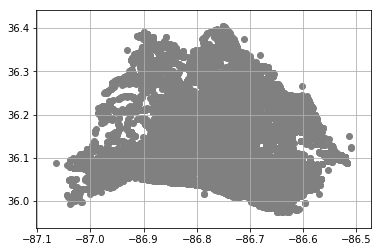

In [96]:
#cop_map.plot(column = 'Tencode Description', figsize = (12, 12), legend = False);
#plt.show();
#neighborhood_beer.plot(column = 'name', figsize = (12, 12), legend = True)
test = cop_map[(cop_map.Longitude>-90) & (cop_map.Longitude<-80)]
plt.scatter(x = test.Longitude, y = test.Latitude, color = 'gray')
plt.grid(True)

plt.show();

In [97]:
test["Tencode Description"].unique()

array(['Business Check', 'Shots Fired', 'Traffic Violation',
       'Want Officer for Investigation / Assistance', 'Suspicious Person',
       'Vehicle Accident - Property Damage', 'Intoxicated Person',
       'Theft', 'Person with Weapon', 'Prowler', 'Burglary - Residence',
       'Burglary - Non-Residence', 'Safety Hazard',
       'Investigate 911 Hang-Up Call', 'Fight / Assault',
       'Disorderly Person', 'Community Policing Activity',
       'Person Screaming', 'Vehicle Accident - Personal Injury',
       'Transport Prisoner / Suspect', 'Holdup / Robbery', 'Shooting',
       'Vehicle Blocking Right of Way', 'Missing Person', 'Fire',
       'Dangerous / Injured Animal', 'Administrative/Special Assignment',
       'Fixed Post', 'Corpse / D. O. A.', 'Suicidal Person',
       'Mentally ILL Person', 'Meal Break', 'Hazardous Liquid / Gas Leak',
       'Person Indecently Exposed', 'Cutting / Stabbing',
       'Personal Relief', 'Bank Robbery', 'Personnel in Serious Danger',
       'Esco

In [102]:
#subset df using the desired descriptions, then pulling just the columns of interest
colstofilter = ['Burglary - Residence', 'Burglary - Non-Residence']
colstokeep = ["Tencode Description", "Longitude", "Latitude", "geometry"]

test_subset = test[test["Tencode Description"].isin(colstofilter)][colstokeep]
test_subset.shape

(31459, 4)

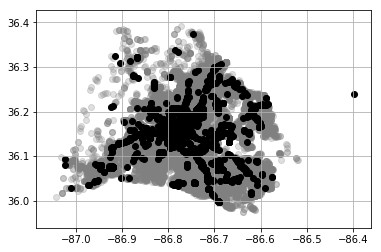

In [109]:
#Overlay the two scatter plots
plt.scatter(x = test_subset.Longitude, y = test_subset.Latitude, color = 'gray', alpha = 0.25)
plt.scatter(x = beer_sales.lng, y = beer_sales.lat, color = 'black');
plt.grid(True)

plt.show();

In [115]:
center = beer_map.geometry.centroid
center_point = center.iloc[0]
# print the types for center and center_point
print('center is :', type(center))
print('center_point is :', type(center_point))

center is : <class 'geopandas.geoseries.GeoSeries'>
center_point is : <class 'shapely.geometry.point.Point'>


In [116]:
# center point has longitude first
print(center_point)

# reverse the order when constructing the array for folium location
urban_center = [center_point.y, center_point.x]

# check the order of urban_center, the location we'll set for our folium map
print(urban_center)

POINT (-86.871678 36.099462)
[36.099462, -86.871678]


In [144]:
#create our map of Nashville and show it
map_Nashville = folium.Map(location =  urban_center)
map_Nashville

In [145]:
for row in neighborhood_beer.iterrows():
    row_values = row[1] 
    location = [row_values['lat'], row_values['lng']]
   
    marker = folium.Marker(location = location)
    
    marker.add_to(map_Nashville)

#display our map
map_Nashville

In [146]:
for ind, (_, row_values) in enumerate(test_subset.iterrows()):
    if ind < 2500:
        location = [row_values['Latitude'], row_values['Longitude']]

        marker = folium.Circle(radius = 1, location = location, color = 'red', fill = True, fill_color = 'red')

        marker.add_to(map_Nashville)

#display our map
map_Nashville